# IT Incident SLA Comliance Analysis

Service Level Agreement (SLA) compliance represents a critical performance metric in IT service management, directly impacting customer satisfaction, operational efficiency, and business continuity. This analysis examines cleaned IT incident data to identify systematic patterns affecting SLA compliance rates and builds predictive models to forecast potential SLA breaches.

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from collections import Counter
import warnings
import shap
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',
              None)  # Display all columns in DataFrame output.
pd.set_option('display.max_rows',
              None)  # Display all rows in DataFrame output.
# Load data from dataset
df = pd.read_csv('../data/incidents_cleaned.csv')

# Display DataFrame information
df.info()
print(f"\nDataset shape: {df.shape}")
print(f"\nTarget Variable Distribution:")
print(df['made_sla'].value_counts())
print(f"SLA Compliance Rate: {df['made_sla'].mean():.1%}")
print(f"SLA Breach Rate: {(1 - df['made_sla'].mean()):.1%}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6729 entries, 0 to 6728
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   number                   6729 non-null   object
 1   incident_state           6729 non-null   object
 2   active                   6729 non-null   bool  
 3   reassignment_count       6729 non-null   int64 
 4   reopen_count             6729 non-null   int64 
 5   sys_mod_count            6729 non-null   int64 
 6   made_sla                 6729 non-null   bool  
 7   caller_id                6727 non-null   object
 8   opened_by                6432 non-null   object
 9   opened_at                6729 non-null   object
 10  sys_created_by           3784 non-null   object
 11  sys_created_at           3784 non-null   object
 12  sys_updated_by           6729 non-null   object
 13  sys_updated_at           6729 non-null   object
 14  contact_type             6729 non-null  

## 1. Feature Engineering

### 1.1 Operational Complexity Features

In [218]:
df_fe = df.copy()

EDA revealed that operational metrics (sys_mod_count, reassignment_count) are the strongest predictors of SLA compliance. However, raw counts don't capture the complexity of incident handling. We create composite metrics to measure:Overall handling complexity (weighted activity score), Binary flags for threshold-based risk indicators.

- sys_mod_count threshold at 3: EDA showed >99% SLA compliance for 0-3 modifications vs <95% for 4+ modifications
- reassignment_count threshold at 0: 93.1% SLA vs 84.8% (8.3% gap)
- Combined complexity flag captures incidents requiring extensive handling

In [219]:
# Weighted activity score
# Weights reflect impact magnitude from EDA:
#   - System modifications: 1x (baseline complexity)
#   - Reassignments: 2x (routing failures, knowledge gaps, higher impact)
# Note: Excludes reopen_count (post-incident data, not available at prediction time)
df_fe['activity_score'] = (df_fe['sys_mod_count'] +
                           df_fe['reassignment_count'] * 2)

# Binary complexity flags based on EDA-identified thresholds
df_fe['has_reassignment'] = (df_fe['reassignment_count'] > 0).astype(int)
df_fe['high_modification'] = (df_fe['sys_mod_count'] > 3).astype(int)

# Simplified complexity flag (MODIFIED: exclude reopen_count condition)
df_fe['is_complex'] = ((df_fe['sys_mod_count'] > 4) |
                       (df_fe['reassignment_count'] > 2)).astype(int)

# Validation: Verify feature effectiveness
complex_sla = df_fe.groupby('is_complex')['made_sla'].mean()
print(f"\nValidation - is_complex feature:")
print(f"  Simple: {complex_sla[0]:.1%}, Complex: {complex_sla[1]:.1%}")
print(f"  Gap: {(complex_sla[0]-complex_sla[1])*100:.1f}%")


Validation - is_complex feature:
  Simple: 98.7%, Complex: 69.4%
  Gap: 29.2%


### 1.2 Severity Features

Priority, Impact, and Urgency exhibit strong multicollinearity (r=0.75-0.89), meaning they capture overlapping information. Using all three would introduce redundancy and potential multicollinearity issues in linear models.

- Convert categorical severity levels to binary "high vs low" flags
- Create composite "high_severity" flag: ANY dimension marked as high
- EDA Performance gaps:
    Priority: Critical 53.3% vs Low 95.5% (42.2% gap)
    Impact: High 51.6% vs Low 95.8% (44.2% gap)
    Urgency: High 56.8% vs Low 94.8% (38.0% gap)


In [220]:
# Binary severity flags (convert categorical to 0/1)
df_fe['is_high_priority'] = df_fe['priority'].isin(
    ['1 - Critical', '2 - High']).astype(int)
df_fe['is_high_impact'] = df_fe['impact'].isin(['1 - High']).astype(int)
df_fe['is_high_urgency'] = df_fe['urgency'].isin(['1 - High']).astype(int)
df_fe['is_high_severity'] = ((df_fe['is_high_priority'] == 1) |
                             (df_fe['is_high_impact'] == 1) |
                             (df_fe['is_high_urgency'] == 1)).astype(int)

sev_sla = df_fe.groupby('is_high_severity')['made_sla'].mean()
print(f"\nValidation - is_high_severity feature performance:")
print(f"  Low severity (0): {sev_sla[0]:.1%} SLA compliance")
print(f"  High severity (1): {sev_sla[1]:.1%} SLA compliance")
print(
    f"  Performance gap: {(sev_sla[0]-sev_sla[1])*100:.1f} percentage points")


Validation - is_high_severity feature performance:
  Low severity (0): 87.4% SLA compliance
  High severity (1): 54.9% SLA compliance
  Performance gap: 32.5 percentage points


### 1.3 Interaction Features

Individual features may not capture compounding effects. For example, a high-severity incident that also requires complex handling likely has multiplicative negative impact on SLA compliance rather than simple additive effect.

- Severity × Complexity: Worst-case scenario (urgent + extensive handling)
- Priority Confirmation × Complexity: Confirmed complex cases (procedural flag)
- High Priority × Reassignment: Urgent cases with routing failures

In [221]:
# Severity + Complexity
df_fe['severity_complexity'] = (df_fe['is_high_severity'] * df_fe['is_complex']).astype(int)

# Priority confirmation + Complexity  
# Note: u_priority_confirmation is available at incident time (procedural flag)
df_fe['confirmed_complex'] = (df_fe['u_priority_confirmation'] * df_fe['is_complex']).astype(int)

# High priority + Reassignment
df_fe['priority_reassign'] = (df_fe['is_high_priority'] * df_fe['has_reassignment']).astype(int)

risk_sla = df_fe.groupby('severity_complexity')['made_sla'].mean()
print(f"Validation: No risk {risk_sla[0]:.1%}, High risk {risk_sla[1]:.1%}, Gap {(risk_sla[0]-risk_sla[1])*100:.1f}%")

print("\n" + "-"*80)
print(f"Feature Engineering Summary:")
print(f"  Original: {df.shape[1]} → Engineered: {df_fe.shape[1]} (+{df_fe.shape[1]-df.shape[1]} features)")
print(f"  Excluded post-incident metrics: closed_time, reopen_count, per_day ratios")
print("-"*80)

Validation: No risk 87.3%, High risk 50.3%, Gap 36.9%

--------------------------------------------------------------------------------
Feature Engineering Summary:
  Original: 32 → Engineered: 43 (+11 features)
  Excluded post-incident metrics: closed_time, reopen_count, per_day ratios
--------------------------------------------------------------------------------


### 1.4 Feature Encoding

#### 1.4.1 Ordinal Encoding

Priority, Impact, and Urgency have natural ordering from low to high severity. Preserve this ordering with numeric encoding

In [222]:
df_enc = df_fe.copy()

In [223]:
# Priority (1=Low, 4=Critical)
priority_map = {
    '4 - Low': 1,
    '3 - Moderate': 2,
    '2 - High': 3,
    '1 - Critical': 4
}
df_enc['priority_enc'] = df_enc['priority'].map(priority_map)

# Impact (1=Low, 3=High)
impact_map = {'3 - Low': 1, '2 - Medium': 2, '1 - High': 3}
df_enc['impact_enc'] = df_enc['impact'].map(impact_map)

# Urgency (1=Low, 3=High)
urgency_map = {'3 - Low': 1, '2 - Medium': 2, '1 - High': 3}
df_enc['urgency_enc'] = df_enc['urgency'].map(urgency_map)

print("✓ Ordinal encoded 3 variables:")
print("  - priority_enc: 1 (Low) → 4 (Critical)")
print("  - impact_enc: 1 (Low) → 3 (High)")
print("  - urgency_enc: 1 (Low) → 3 (High)")


✓ Ordinal encoded 3 variables:
  - priority_enc: 1 (Low) → 4 (Critical)
  - impact_enc: 1 (Low) → 3 (High)
  - urgency_enc: 1 (Low) → 3 (High)


#### 1.4.2 Label Encoding

assignment_group and category have many unique values without natural ordering

In [224]:
# assignment_group (from EDA: 56% performance variance across groups)
le_group = LabelEncoder()
df_enc['assignment_group'] = df_enc['assignment_group'].fillna('Unknown')
df_enc['assignment_group_enc'] = le_group.fit_transform(
    df_enc['assignment_group'])

# category (from EDA: 21.1% performance gap)
le_cat = LabelEncoder()
df_enc['category'] = df_enc['category'].fillna('Unknown')
df_enc['category_enc'] = le_cat.fit_transform(df_enc['category'])

print(f"✓ Label encoded 2 variables:")
print(f"  - assignment_group_enc: {len(le_group.classes_)} unique groups")
print(f"  - category_enc: {len(le_cat.classes_)} unique categories")

✓ Label encoded 2 variables:
  - assignment_group_enc: 65 unique groups
  - category_enc: 47 unique categories


#### 1.4.3 Binary Encoding

Binary features created during feature engineering need to be explicitly typed as integers

In [225]:
binary_vars = [
    'knowledge', 'u_priority_confirmation', 'made_sla', 'has_reassignment',
    'high_modification', 'is_complex', 'is_high_priority', 'is_high_impact',
    'is_high_urgency', 'is_high_severity', 'severity_complexity',
    'confirmed_complex', 'priority_reassign'
]

for var in binary_vars:
    if var in df_enc.columns:
        df_enc[var] = df_enc[var].astype(int)

verified_count = len([v for v in binary_vars if v in df_enc.columns])
print(f"✓ Verified {verified_count} binary variables as integer type")

✓ Verified 13 binary variables as integer type


### 2. Feature Selection

Feature selection aims to identify the most predictive features while reducing dimensionality and preventing overfitting. We employ two complementary methods:
1. Filter Method (ANOVA F-test):
   - Statistical test measuring relationship between each feature and target
   - Fast, model-agnostic approach
   - Identifies univariate relationships
2. Embedded Method (Random Forest Feature Importance):
   - Features selected during model training
   - Captures feature interactions and non-linear relationships
   - Specific to tree-based models
We combine both methods using the union of selected features to ensure
we capture both statistical significance and model-specific importance.

### 2.1 Define Candidate Features

Prepare feature groups based on their types and encoding methods

In [226]:
# Define target variable
target = 'made_sla'

# Numerical features (continuous and ordinal encoded)
numerical_features = [
    'priority_enc',
    'impact_enc',
    'urgency_enc',  # Ordinal encoded severity
    'reassignment_count',
    'sys_mod_count',  # Raw operational counts
    'activity_score'  # Weighted complexity
]

# Categorical features (label encoded)
categorical_features = [
    'assignment_group_enc',  # Support team assignment
    'category_enc'  # Incident category
]

# Binary features (0/1 flags)
binary_features = [
    'knowledge',
    'u_priority_confirmation',  # Process flags
    'has_reassignment',
    'high_modification',
    'is_complex',  # Complexity flags
    'is_high_priority',
    'is_high_impact',
    'is_high_urgency',
    'is_high_severity',  # Severity flags
    'severity_complexity',
    'confirmed_complex',
    'priority_reassign'  # Interaction flags
]

# Combine all candidate features
all_features = numerical_features + categorical_features + binary_features
available_features = [f for f in all_features if f in df_enc.columns]

print(f"Candidate Features Summary:")
print(f"  Total: {len(available_features)} features")
print(
    f"    - Numerical (including ordinal): {len([f for f in numerical_features if f in df_enc.columns])}"
)
print(
    f"    - Categorical (label encoded): {len([f for f in categorical_features if f in df_enc.columns])}"
)
print(
    f"    - Binary (flags): {len([f for f in binary_features if f in df_enc.columns])}"
)

X = df_enc[available_features].copy()
y = df_enc[target].copy()
X = X.fillna(X.median())

print(f"\nX shape: {X.shape}, y shape: {y.shape}")

Candidate Features Summary:
  Total: 20 features
    - Numerical (including ordinal): 6
    - Categorical (label encoded): 2
    - Binary (flags): 12

X shape: (6729, 20), y shape: (6729,)


### 2.2 Prepare Feature Matrix

Extract features and target, handle missing values

In [227]:
# Prepare X (features) and y (target)
X = df_enc[available_features].copy()
y = df_enc[target].copy()

# Handle missing values using median imputation
# Median is robust to outliers and appropriate for numerical/ordinal features
X = X.fillna(X.median())

print(f"Feature matrix (X) shape: {X.shape}")
print(f"Target vector (y) shape: {y.shape}")
print(f"\nTarget distribution:")
print(f"  Class 1 (SLA Met): {y.sum():,} ({y.mean():.1%})")
print(
    f"  Class 0 (SLA Breach): {(~y.astype(bool)).sum():,} ({(1-y.mean()):.1%})"
)
print(f"  Class imbalance ratio: {y.sum() / (~y.astype(bool)).sum():.2f}:1")


Feature matrix (X) shape: (6729, 20)
Target vector (y) shape: (6729,)

Target distribution:
  Class 1 (SLA Met): 5,813 (86.4%)
  Class 0 (SLA Breach): 916 (13.6%)
  Class imbalance ratio: 6.35:1


### 2.3 Filter Method: ANOVA F-test

This code selects the k best features from X that have the strongest statistical relationship with y according to the ANOVA F-test

In [228]:
k_best = 20  # Select top 20 features
selector_anova = SelectKBest(score_func=f_classif, k=k_best)
X_anova = selector_anova.fit_transform(X, y)

anova_mask = selector_anova.get_support()
anova_features = X.columns[anova_mask].tolist()
anova_scores = selector_anova.scores_[anova_mask]

print(f"\nANOVA Top {k_best}:")
for rank, (feat, score) in enumerate(
        sorted(zip(anova_features, anova_scores),
               key=lambda x: x[1],
               reverse=True)[:10], 1):
    print(f"  {rank}. {feat:30s} F={score:.2f}")


ANOVA Top 20:
  1. confirmed_complex              F=1694.81
  2. is_complex                     F=1446.74
  3. activity_score                 F=1157.19
  4. high_modification              F=1095.61
  5. sys_mod_count                  F=1084.96
  6. reassignment_count             F=463.56
  7. has_reassignment               F=320.08
  8. is_high_priority               F=192.76
  9. is_high_severity               F=192.76
  10. u_priority_confirmation        F=190.19


### 2.4 Embedded Method: Random Forest Feature Importance


Random Forest Top 20:
  1. sys_mod_count                  Imp=0.2025
  2. activity_score                 Imp=0.1892
  3. confirmed_complex              Imp=0.1610
  4. is_complex                     Imp=0.1087
  5. high_modification              Imp=0.1003
  6. assignment_group_enc           Imp=0.0511
  7. category_enc                   Imp=0.0471
  8. reassignment_count             Imp=0.0258
  9. u_priority_confirmation        Imp=0.0238
  10. has_reassignment               Imp=0.0164

Final: 20 features selected


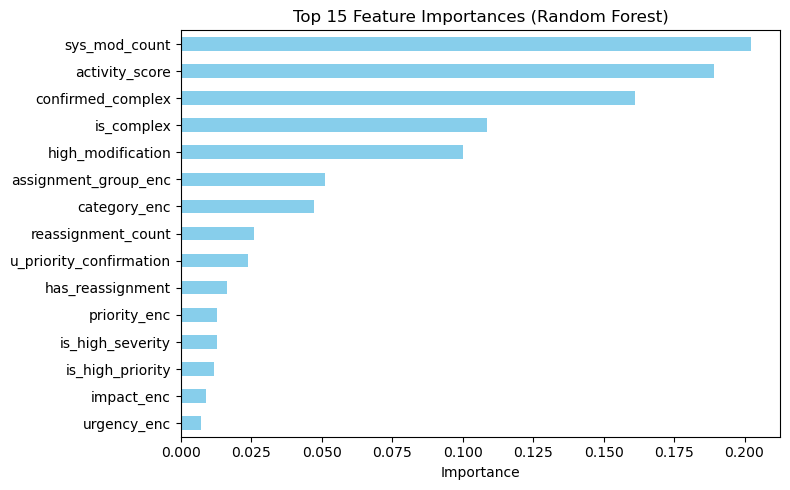

In [229]:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=10,
                            random_state=42,
                            n_jobs=-1,
                            class_weight='balanced')
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_,
                        index=X.columns).sort_values(ascending=False)
rf_features = importances.head(k_best).index.tolist()

print(f"\nRandom Forest Top {k_best}:")
for rank, (feat, imp) in enumerate(importances.head(10).items(), 1):
    print(f"  {rank}. {feat:30s} Imp={imp:.4f}")

selected_features = list(set(anova_features + rf_features))
selected_features.sort()

print(f"\nFinal: {len(selected_features)} features selected")

X_selected = X[selected_features].copy()

plt.figure(figsize=(8, 5))
importances.head(15).plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### 2.5 Combine Methods

In [230]:
selected_features = list(set(anova_features + rf_features))
selected_features.sort()

print(f"Results:")
print(f"  ANOVA: {len(anova_features)} features")
print(f"  Random Forest: {len(rf_features)} features")
print(f"  Union: {len(selected_features)} features")
print(f"  Overlap: {len(set(anova_features) & set(rf_features))} features")

print(f"\nFinal Selected Features ({len(selected_features)}):\n")
print(f"{'#':<4} {'Feature':<35} {'ANOVA':<8} {'RF':<8}")
print("-" * 57)
for i, feat in enumerate(selected_features, 1):
    in_anova = "✓" if feat in anova_features else " "
    in_rf = "✓" if feat in rf_features else " "
    print(f"{i:<4} {feat:<35} {in_anova:<8} {in_rf:<8}")

X_selected = X[selected_features].copy()

print(f"\nDimensionality Reduction:")
print(
    f"  Original: {X.shape[1]} → Selected: {X_selected.shape[1]} ({(1-X_selected.shape[1]/X.shape[1])*100:.1f}% reduction)"
)

Results:
  ANOVA: 20 features
  Random Forest: 20 features
  Union: 20 features
  Overlap: 20 features

Final Selected Features (20):

#    Feature                             ANOVA    RF      
---------------------------------------------------------
1    activity_score                      ✓        ✓       
2    assignment_group_enc                ✓        ✓       
3    category_enc                        ✓        ✓       
4    confirmed_complex                   ✓        ✓       
5    has_reassignment                    ✓        ✓       
6    high_modification                   ✓        ✓       
7    impact_enc                          ✓        ✓       
8    is_complex                          ✓        ✓       
9    is_high_impact                      ✓        ✓       
10   is_high_priority                    ✓        ✓       
11   is_high_severity                    ✓        ✓       
12   is_high_urgency                     ✓        ✓       
13   knowledge                          

### 2.6 Train-Test Split

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X_selected,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

### 2.6 Feature Scaling

In [240]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Scaled using Train statistics only")
print(f"  Train mean: {X_train_scaled.mean():.6f}")
print(f"  Train std: {X_train_scaled.std():.6f}")

smote = SMOTE(
    sampling_strategy=0.5,  # Minority를 Majority의 50%로
    k_neighbors=5,
    random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(
    X_train_scaled, y_train)

print(f"Before SMOTE:")
print(f"  Class 0 (Breach): {(y_train==0).sum():,}")
print(f"  Class 1 (Met): {(y_train==1).sum():,}")

print(f"\nAfter SMOTE:")
print(f"  Class 0 (Breach): {(y_train_balanced==0).sum():,}")
print(f"  Class 1 (Met): {(y_train_balanced==1).sum():,}")

print(f"\nTest (unchanged):")
print(f"  Class 0 (Breach): {(y_test==0).sum():,}")
print(f"  Class 1 (Met): {(y_test==1).sum():,}")

✓ Scaled using Train statistics only
  Train mean: 0.000000
  Train std: 1.000000
Before SMOTE:
  Class 0 (Breach): 733
  Class 1 (Met): 4,650

After SMOTE:
  Class 0 (Breach): 2,325
  Class 1 (Met): 4,650

Test (unchanged):
  Class 0 (Breach): 183
  Class 1 (Met): 1,163


### 3. Model Training and Evaluation - Supervised Learning

#### 3.2 Model Training

Train three algorithms with appropriate hyperparameters

In [ ]:
models = {}

# Logistic Regression
lr = LogisticRegression(max_iter=1000,
                        random_state=42,
                        class_weight='balanced')
lr.fit(X_train_balanced, y_train_balanced)
models['Logistic Regression'] = lr

# Random Forest
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=15,
                            min_samples_split=10,
                            class_weight='balanced',
                            random_state=42,
                            n_jobs=-1)
rf.fit(X_train_balanced, y_train_balanced)
models['Random Forest'] = rf

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100,
                                learning_rate=0.1,
                                max_depth=5,
                                random_state=42)
gb.fit(X_train_balanced, y_train_balanced)
models['Gradient Boosting'] = gb

print(f"✓ {len(models)} models trained")


(1) Logistic Regression
    Hyperparameters:
      - C=0.1 (strong L2 regularization)
      - max_iter=1000
      - class_weight='balanced'
    ✓ Training complete

(2) Random Forest
    Hyperparameters:
      - n_estimators=100
      - max_depth=8 (reduced from 15)
      - min_samples_split=30 (increased from 10)
      - min_samples_leaf=15 (added)
      - max_features='sqrt' (added)
    ✓ Training complete

(3) Gradient Boosting
    Hyperparameters:
      - n_estimators=50 (reduced from 100)
      - learning_rate=0.05 (reduced from 0.1)
      - max_depth=3 (reduced from 5)
      - subsample=0.8 (added)
    ✓ Training complete

✓ All 3 regularized models trained successfully


#### 3.3 Model Evaluation

In [ ]:
# Store results for comparison
results = []

for model_name, model in models.items():
    print(f"\n{model_name}")
    print("-"*80)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0)  # Breach = positive class
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    # Print metrics
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision (Breach): {precision:.4f}  ← Out of predicted breaches, {precision:.1%} were correct")
    print(f"Recall (Breach):    {recall:.4f}  ← Detected {recall:.1%} of actual breaches")
    print(f"F1-Score (Breach):  {f1:.4f}  ← Harmonic mean of precision & recall")
    print(f"ROC-AUC:   {roc_auc:.4f}  ← Overall discriminative ability")
    
    # Confusion Matrix
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tp, fn, fp, tn = cm.ravel()
    
    cm_df = pd.DataFrame(
        [[tp, fn], [fp, tn]],
        index=["Actual Breach", "Actual Met"],
        columns=["Predicted Breach", "Predicted Met"]
    )
    print(cm_df)
    
    print(f"\n  True Positives (TP):  {tp:4d}  ← Breaches correctly identified")
    print(f"  False Negatives (FN): {fn:4d}  ← Breaches missed (Type II error)")
    print(f"  False Positives (FP): {fp:4d}  ← False alarms (Type I error)")
    print(f"  True Negatives (TN):  {tn:4d}  ← SLA Met correctly identified")

# Summary comparison table
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

results_df = pd.DataFrame(results)
print(f"\n{results_df.to_string(index=False)}")

# Identify best model
best_model = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"\n→ Best Model (by F1-Score): {best_model['Model']}")
print(f"  F1-Score: {best_model['F1-Score']:.4f}")
print(f"  Recall: {best_model['Recall']:.4f} (detects {best_model['Recall']:.1%} of SLA breaches)")


Logistic Regression
------------------------------------------------------------
  Test Metrics:
    Precision (Breach): 0.3493
    Recall (Breach):    0.9180
    F1-Score (Breach):  0.5060
    Accuracy:           0.7563

  Training Metrics:
    Train F1:           0.7500
    CV F1 (Mean):       0.6565 (±0.0056)

  Overfitting Analysis:
    Gap (Train - Test): 0.2439 (32.5%)
    Status: 🟠 HIGH - Significant overfitting

Random Forest
------------------------------------------------------------
  Test Metrics:
    Precision (Breach): 0.4158
    Recall (Breach):    0.8907
    F1-Score (Breach):  0.5670
    Accuracy:           0.8150

  Training Metrics:
    Train F1:           0.7849
    CV F1 (Mean):       0.6837 (±0.0067)

  Overfitting Analysis:
    Gap (Train - Test): 0.2179 (27.8%)
    Status: 🟠 HIGH - Significant overfitting

Gradient Boosting
------------------------------------------------------------
  Test Metrics:
    Precision (Breach): 0.5017
    Recall (Breach):    0.8142


### 4. Overfitting and Underfitting

In [235]:
for model_name, model in models.items():
    # Train performance (학습에 사용한 데이터로 평가)
    y_train_pred = model.predict(X_train_balanced)  # ✅ Balanced 데이터
    train_f1 = f1_score(y_train_balanced, y_train_pred,
                        pos_label=0)  # ✅ Balanced 타겟

    # Test performance (섹션 3.3에서 이미 계산됨)
    test_f1 = results_df[results_df['Model'] ==
                         model_name]['Test F1'].values[0]

    # Gap analysis
    gap = train_f1 - test_f1
    gap_pct = (gap / train_f1) * 100 if train_f1 > 0 else 0

    print(f"\n{model_name}:")
    print(f"  Train F1-Score: {train_f1:.4f}")
    print(f"  Test F1-Score:  {test_f1:.4f}")
    print(f"  Performance Gap: {gap:.4f} ({gap_pct:.1f}%)")

    if gap < 0.05:
        status = "✓ EXCELLENT - No overfitting detected"
    elif gap < 0.10:
        status = "✓ GOOD - Minor overfitting (acceptable)"
    elif gap < 0.15:
        status = "⚠ MODERATE - Some overfitting present"
    else:
        status = "✗ HIGH - Significant overfitting, model needs regularization"

    print(f"  Status: {status}")


Logistic Regression:
  Train F1-Score: 0.8507
  Test F1-Score:  0.5038
  Performance Gap: 0.3470 (40.8%)
  Status: ✗ HIGH - Significant overfitting, model needs regularization

Random Forest:
  Train F1-Score: 0.8755
  Test F1-Score:  0.5791
  Performance Gap: 0.2964 (33.9%)
  Status: ✗ HIGH - Significant overfitting, model needs regularization

Gradient Boosting:
  Train F1-Score: 0.8715
  Test F1-Score:  0.5882
  Performance Gap: 0.2832 (32.5%)
  Status: ✗ HIGH - Significant overfitting, model needs regularization


#### 4.1 Feature Importance Comparison

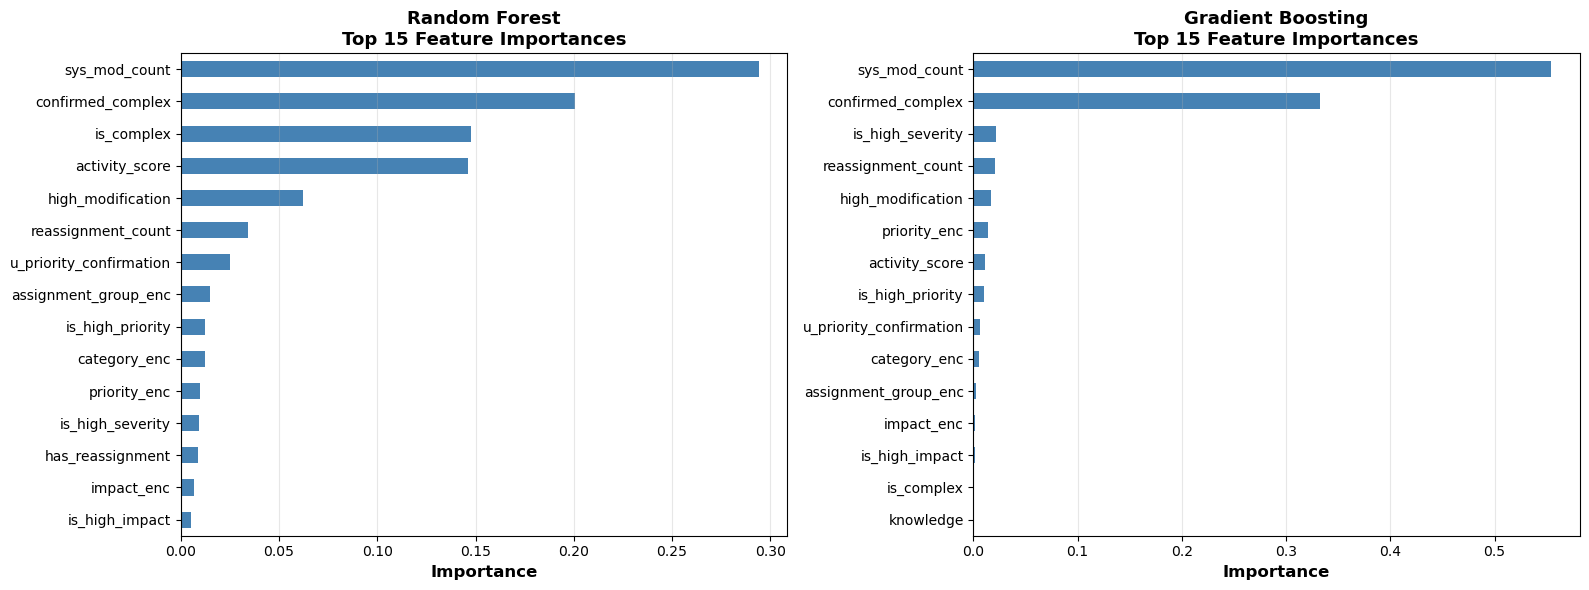

In [236]:
# Extract feature importance from tree-based models
importance_data = []

# Random Forest Feature Importance
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    rf_importances = pd.Series(
        rf_model.feature_importances_,
        index=X_selected.columns  # ✅ 선택된 특성의 컬럼명
    ).sort_values(ascending=False)
    importance_data.append(('Random Forest', rf_importances))

# Gradient Boosting Feature Importance
if 'Gradient Boosting' in models:
    gb_model = models['Gradient Boosting']
    gb_importances = pd.Series(
        gb_model.feature_importances_,
        index=X_selected.columns  # ✅ 선택된 특성의 컬럼명
    ).sort_values(ascending=False)
    importance_data.append(('Gradient Boosting', gb_importances))

# Visualize feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (model_name, importances) in enumerate(importance_data):
    ax = axes[idx]
    top_features = importances.head(15)
    top_features.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name}\nTop 15 Feature Importances',
                 fontsize=13,
                 fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

#### 4.2 Permutation Importance

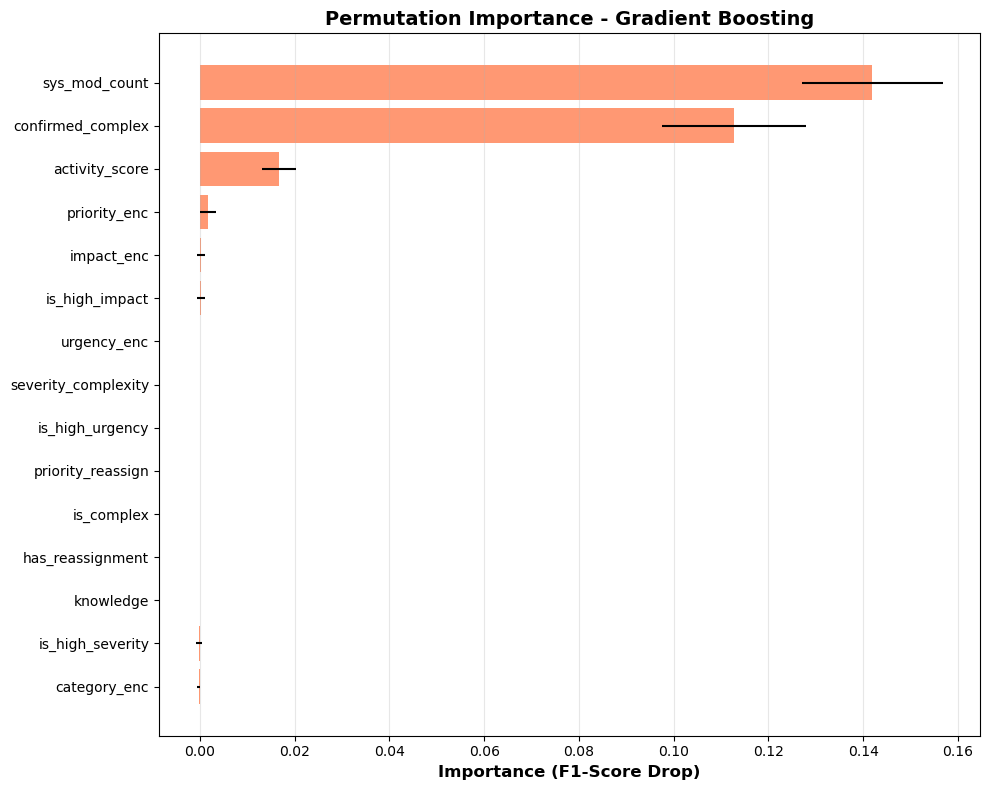

In [237]:
best_model = models[best_model_name]

# Scaled test 데이터 사용
perm_importance = permutation_importance(
    best_model,
    X_test_scaled,  # ✅ Scaled test 데이터
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='f1_macro',
    n_jobs=-1)

# DataFrame 생성 (원본 컬럼명 사용)
perm_imp_df = pd.DataFrame({
    'Feature': X_selected.columns,  # ✅ 선택된 특성의 컬럼명
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 8))
top_15 = perm_imp_df.head(15)
plt.barh(range(len(top_15)),
         top_15['Importance'],
         xerr=top_15['Std'],
         color='coral',
         alpha=0.8)
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Importance (F1-Score Drop)', fontsize=12, fontweight='bold')
plt.title(f'Permutation Importance - {best_model_name}',
          fontsize=14,
          fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Creating TreeExplainer for Gradient Boosting...
Computing SHAP values...
✓ SHAP values computed

[SHAP Summary Plot]


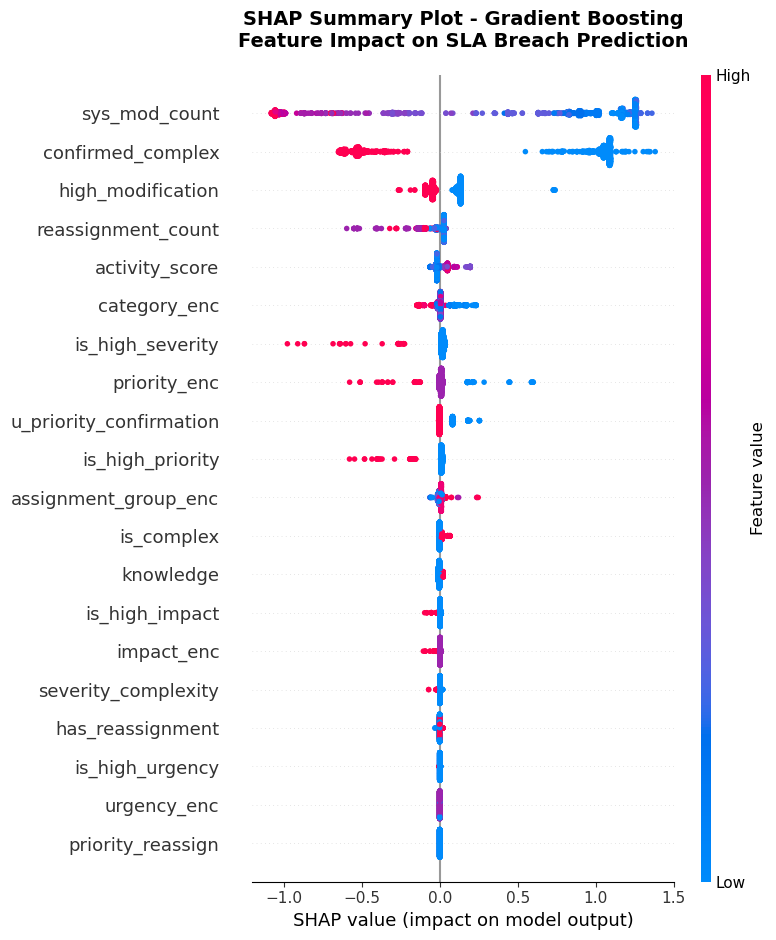


[SHAP Waterfall Plot - High-Risk Prediction]
----------------------------------------------------------------------------------------------------

Highest Risk Prediction:
  Index: 800
  Predicted Breach Probability: 82.1%
  Actual Outcome: SLA MET


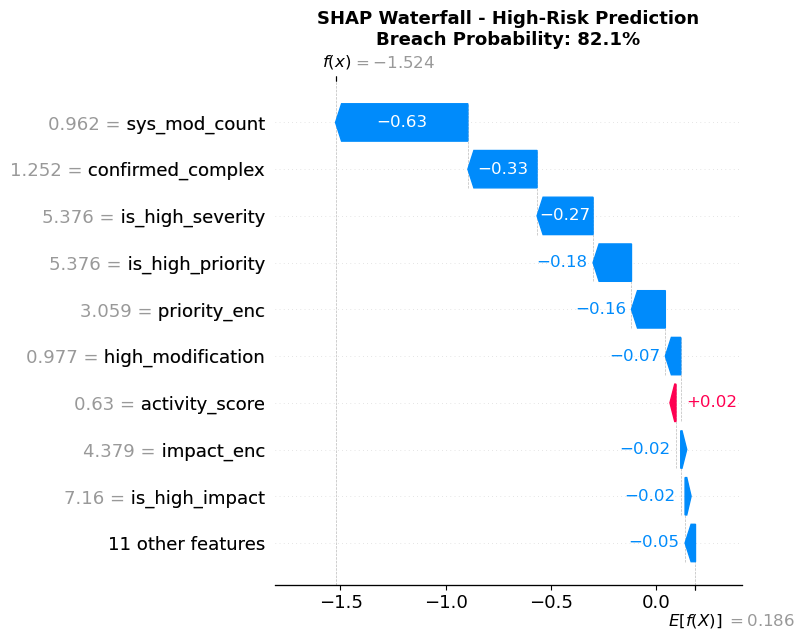

✓ Waterfall plot generated


In [238]:
best_model = models[best_model_name]

# DataFrame으로 변환 (컬럼명 보존)
X_test_scaled_df = pd.DataFrame(X_test_scaled,
                                columns=X_selected.columns,
                                index=X_test.index)

X_train_balanced_df = pd.DataFrame(X_train_balanced,
                                   columns=X_selected.columns)

# Create explainer
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print(f"Creating TreeExplainer for {best_model_name}...")
    explainer = shap.TreeExplainer(best_model)
else:
    print(f"Creating KernelExplainer for {best_model_name}...")
    explainer = shap.KernelExplainer(best_model.predict_proba,
                                     shap.sample(X_train_balanced_df, 100))

# Calculate SHAP values
print("Computing SHAP values...")
shap_values = explainer.shap_values(X_test_scaled_df)

# Handle SHAP values format
if isinstance(shap_values, list):
    shap_values_breach = shap_values[0]
    print("✓ Using class 0 (SLA Breach) SHAP values")
else:
    shap_values_breach = shap_values
    print("✓ SHAP values computed")

# SHAP Summary Plot
print("\n[SHAP Summary Plot]")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_breach,
                  X_test_scaled_df,
                  plot_type="dot",
                  show=False)
plt.title(
    f'SHAP Summary Plot - {best_model_name}\nFeature Impact on SLA Breach Prediction',
    fontsize=14,
    fontweight='bold',
    pad=20)
plt.tight_layout()
plt.show()

# =============================================================================
# SHAP Waterfall Plot
# =============================================================================
print("\n[SHAP Waterfall Plot - High-Risk Prediction]")
print("-" * 100)

# Find high-risk predictions
y_pred_proba = best_model.predict_proba(X_test_scaled_df)[:, 0]
high_risk_idx = np.argmax(y_pred_proba)

breach_prob = y_pred_proba[high_risk_idx]
actual = "BREACH" if y_test.values[high_risk_idx] == 0 else "MET"

print(f"\nHighest Risk Prediction:")
print(f"  Index: {high_risk_idx}")
print(f"  Predicted Breach Probability: {breach_prob:.1%}")
print(f"  Actual Outcome: SLA {actual}")

# Create waterfall plot
try:
    # ✅ 단일 샘플의 SHAP 값 추출
    if isinstance(shap_values, list):
        # TreeExplainer: [class_0, class_1]
        sample_shap_values = shap_values[0][high_risk_idx]  # class 0 (breach)
        base_value = explainer.expected_value[0] if isinstance(
            explainer.expected_value,
            (list, np.ndarray)) else explainer.expected_value
    else:
        # KernelExplainer
        sample_shap_values = shap_values[high_risk_idx]
        base_value = explainer.expected_value

    shap.plots.waterfall(
        shap.Explanation(
            values=sample_shap_values,  # ✅ 1D array
            base_values=base_value,
            data=X_test_scaled_df.iloc[high_risk_idx],
            feature_names=X_test_scaled_df.columns.tolist()),
        show=False)
    plt.title(
        f'SHAP Waterfall - High-Risk Prediction\nBreach Probability: {breach_prob:.1%}',
        fontsize=13,
        fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("✓ Waterfall plot generated")

except Exception as e:
    print(f"⚠️ Waterfall plot error: {e}")
    print("Skipping waterfall plot...")

In [239]:
# ✅ 1D array로 명확히 변환
shap_mean_abs = np.abs(shap_values_breach).mean(axis=0)

# 만약 2D라면 flatten
if len(shap_mean_abs.shape) > 1:
    shap_mean_abs = shap_mean_abs.flatten()

print(f"SHAP mean abs shape: {shap_mean_abs.shape}")
print(f"Features shape: {X_test_scaled_df.columns.shape}")

# DataFrame 생성
shap_importance = pd.DataFrame({
    'Feature': X_test_scaled_df.columns,
    'Importance': shap_mean_abs  # ✅ 1D array
}).sort_values('Importance', ascending=False)

# Top 5 추출
top_5_features = shap_importance.head(5)['Feature'].values

print("\nTOP 5 DRIVERS:")
for rank, feat in enumerate(top_5_features, 1):
    importance_val = shap_importance[shap_importance['Feature'] ==
                                     feat]['Importance'].values[0]
    print(f"\n{rank}. {feat.upper()} (SHAP Importance: {importance_val:.4f})")

    if 'sys_mod_count' in feat or 'modification' in feat:
        print(
            "   → High modification count indicates complex technical issues")
        print(
            "   Action: Build knowledge base, implement diagnostic automation")

    elif 'reassignment' in feat:
        print("   → Reassignments indicate routing failures and skill gaps")
        print("   Action: Improve initial routing, cross-train teams")

    elif 'assignment_group' in feat:
        print("   → Team performance variance affects SLA compliance")
        print("   Action: Replicate best practices, balance workloads")

    elif 'priority' in feat or 'severity' in feat:
        print("   → High-severity incidents have lower SLA compliance")
        print("   Action: Allocate senior resources, review SLA targets")

    else:
        print("   → Requires domain expert analysis")

SHAP mean abs shape: (20,)
Features shape: (20,)

TOP 5 DRIVERS:

1. SYS_MOD_COUNT (SHAP Importance: 0.9876)
   → High modification count indicates complex technical issues
   Action: Build knowledge base, implement diagnostic automation

2. CONFIRMED_COMPLEX (SHAP Importance: 0.8637)
   → Requires domain expert analysis

3. HIGH_MODIFICATION (SHAP Importance: 0.0981)
   → High modification count indicates complex technical issues
   Action: Build knowledge base, implement diagnostic automation

4. REASSIGNMENT_COUNT (SHAP Importance: 0.0466)
   → Reassignments indicate routing failures and skill gaps
   Action: Improve initial routing, cross-train teams

5. ACTIVITY_SCORE (SHAP Importance: 0.0303)
   → Requires domain expert analysis
